In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV
df = pd.read_csv("PlayerStats.csv")

# Keep Clemson
clem = df[df["PlayerTeam"] == "Clemson"].copy()

# Make sure GameDate is a datetime
clem["GameDate"] = pd.to_datetime(clem["GameDate"])

# Creates game-level stats
game_stats = (
    clem
    .groupby(["GameID", "GameDate"])
    .agg(
        TeamRuns=("Hitter_Runs", "sum"),
        RunsAllowed=("Pitcher_Runs", "sum")
    )
    .reset_index()
    .sort_values("GameDate")
)

game_stats["Win"] = game_stats["TeamRuns"] > game_stats["RunsAllowed"]
game_stats["CumWins"] = game_stats["Win"].cumsum()

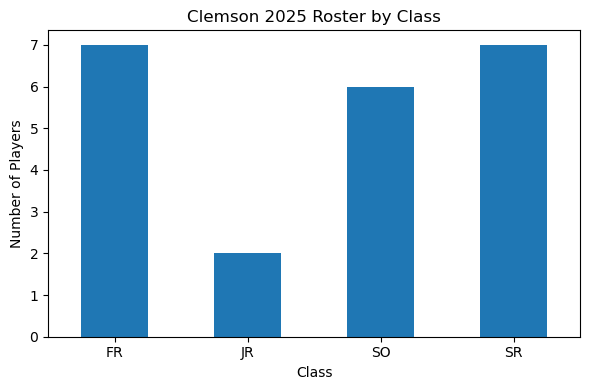

In [2]:
# ROSTER CLASS DISTRIBUTION

# One row per player, with their dominant class
roster = clem.groupby("PlayerName")["Class"].agg(lambda x: x.mode().iloc[0])

class_counts = roster.value_counts().sort_index()  # FR, JR, SO, SR order

plt.figure(figsize=(6, 4))
class_counts.plot(kind="bar")

plt.title("Clemson 2025 Roster by Class")
plt.xlabel("Class")
plt.ylabel("Number of Players")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

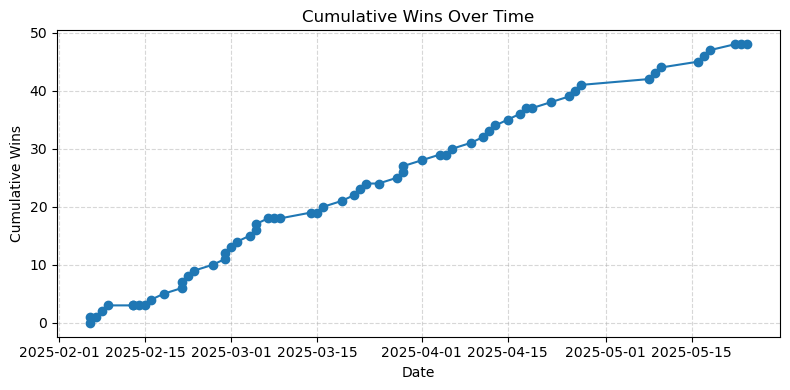

In [5]:
# SEASON DEVELOPMENT: CUMULATIVE WINS

plt.figure(figsize=(8, 4))
plt.plot(game_stats["GameDate"], game_stats["CumWins"], marker="o")

plt.title("Cumulative Wins Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Wins")

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


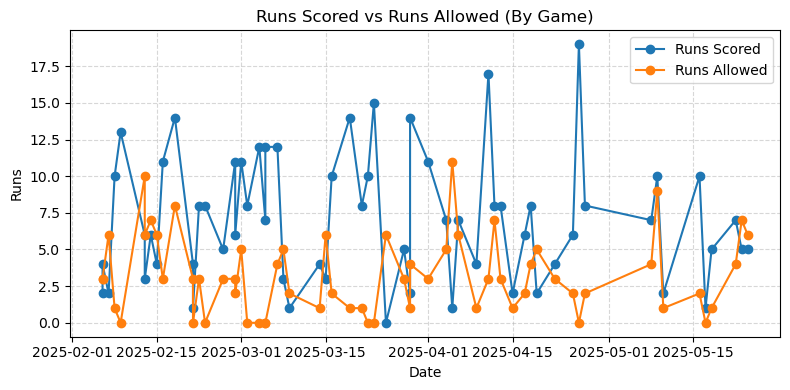

In [4]:
# runs scored vs runs allowed by game (line chart)

plt.figure(figsize=(8, 4))
plt.plot(game_stats["GameDate"], game_stats["TeamRuns"], marker="o", label="Runs Scored")
plt.plot(game_stats["GameDate"], game_stats["RunsAllowed"], marker="o", label="Runs Allowed")

plt.title("Runs Scored vs Runs Allowed (By Game)")
plt.xlabel("Date")
plt.ylabel("Runs")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

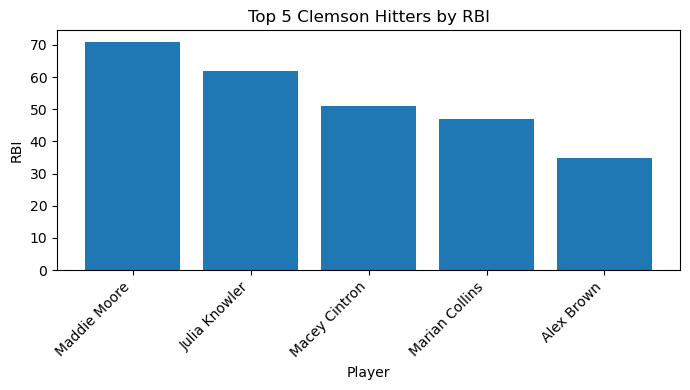

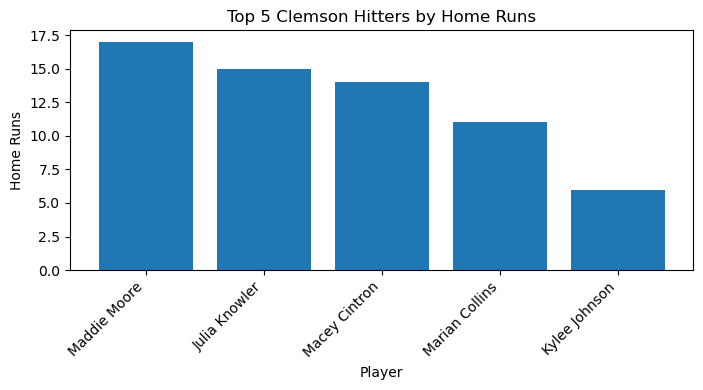

In [6]:
# HITTING STATS BY PLAYER

batting = (
    clem
    .groupby("PlayerName")
    .agg(
        RBI=("Hitter_RunnersBattedIn", "sum"),
        HR=("Hitter_HomeRun", "sum"),
        Runs=("Hitter_Runs", "sum"),
        Hits=("Hitter_Hits", "sum")
    )
    .reset_index()
)

# Sort and keep top N
TOP_N = 5

top_rbi = batting.sort_values("RBI", ascending=False).head(TOP_N)
top_hr  = batting.sort_values("HR", ascending=False).head(TOP_N)

# RBI leaders
plt.figure(figsize=(7, 4))
plt.bar(top_rbi["PlayerName"], top_rbi["RBI"])
plt.title(f"Top {TOP_N} Clemson Hitters by RBI")
plt.xlabel("Player")
plt.ylabel("RBI")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# HR leaders
plt.figure(figsize=(7, 4))
plt.bar(top_hr["PlayerName"], top_hr["HR"])
plt.title(f"Top {TOP_N} Clemson Hitters by Home Runs")
plt.xlabel("Player")
plt.ylabel("Home Runs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

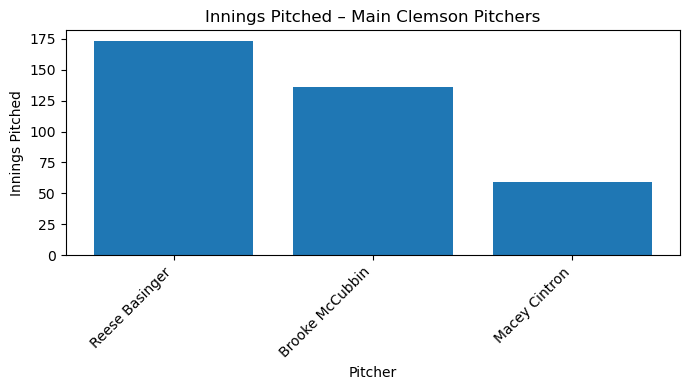

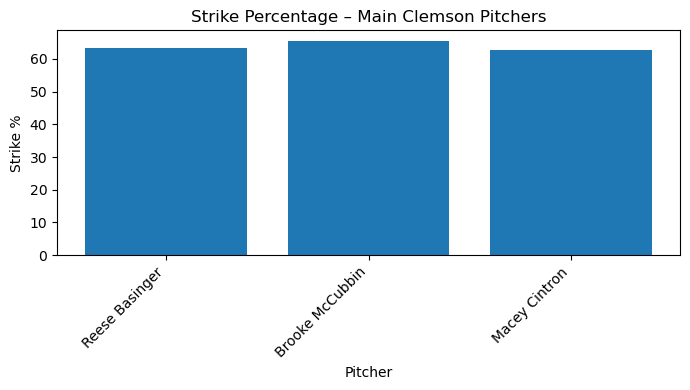

In [10]:
# PITCHING STATS

pitching = (
    clem
    .groupby("PlayerName")
    .agg(
        IP=("Pitcher_InningsPitched", "sum"),
        RunsAllowed=("Pitcher_Runs", "sum"),
        K=("Pitcher_StrikeOuts", "sum"),
        Pitches=("Pitcher_Pitches", "sum"),
        Strikes=("Pitcher_Strikes", "sum")
    )
    .reset_index()
)

# Only keep pitchers that played (IP > 0)
pitching = pitching[pitching["IP"] > 0].copy()
pitching["StrikePct"] = (pitching["Strikes"] / pitching["Pitches"]) * 100

# Focus on main pitchers: IP >= 20 (tweak threshold if needed)
main_pitchers = pitching[pitching["IP"] >= 20].sort_values("IP", ascending=False)

# Innings pitched (workload)
plt.figure(figsize=(7, 4))
plt.bar(main_pitchers["PlayerName"], main_pitchers["IP"])
plt.title("Innings Pitched – Main Clemson Pitchers")
plt.xlabel("Pitcher")
plt.ylabel("Innings Pitched")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Strike percentage
plt.figure(figsize=(7, 4))
plt.bar(main_pitchers["PlayerName"], main_pitchers["StrikePct"])
plt.title("Strike Percentage – Main Clemson Pitchers")
plt.xlabel("Pitcher")
plt.ylabel("Strike %")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

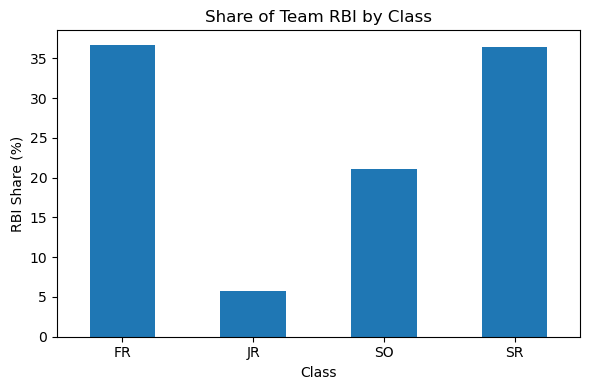

In [11]:
# LEADERSHIP: RBI SHARE BY CLASS

rbi_by_class = (
    clem
    .groupby("Class")["Hitter_RunnersBattedIn"]
    .sum()
    .sort_index()   # FR, JR, SO, SR order-ish; change if you want
)

total_rbi = rbi_by_class.sum()
rbi_share = (rbi_by_class / total_rbi) * 100

plt.figure(figsize=(6, 4))
rbi_share.plot(kind="bar")
plt.title("Share of Team RBI by Class")
plt.xlabel("Class")
plt.ylabel("RBI Share (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

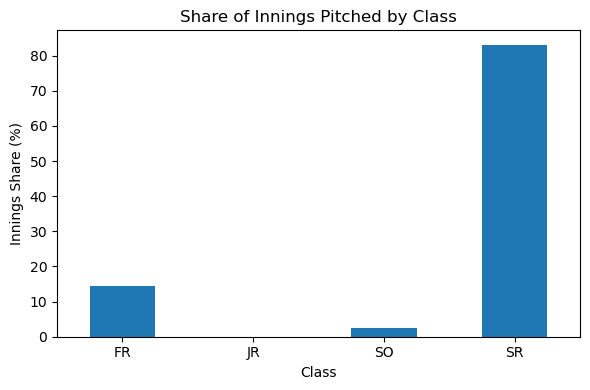

In [12]:
# LEADERSHIP: INNINGS PITCHED SHARE BY CLASS

ip_by_class = (
    clem
    .groupby("Class")["Pitcher_InningsPitched"]
    .sum()
    .sort_index()
)

total_ip = ip_by_class.sum()
ip_share = (ip_by_class / total_ip) * 100

plt.figure(figsize=(6, 4))
ip_share.plot(kind="bar")
plt.title("Share of Innings Pitched by Class")
plt.xlabel("Class")
plt.ylabel("Innings Share (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [8]:
total_runs = game_stats["TeamRuns"].sum()
total_allowed = game_stats["RunsAllowed"].sum()
n_games = len(game_stats)

print("Record:", game_stats["Win"].sum(), "-", (~game_stats["Win"]).sum())
print("Average runs scored per game:", total_runs / n_games)
print("Average runs allowed per game:", total_allowed / n_games)
print("Run differential:", total_runs - total_allowed)

Record: 48 - 14
Average runs scored per game: 7.080645161290323
Average runs allowed per game: 3.225806451612903
Run differential: 239


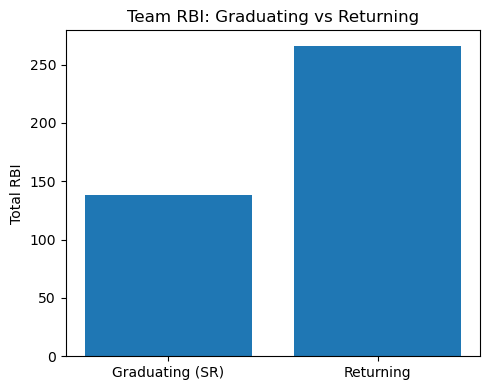

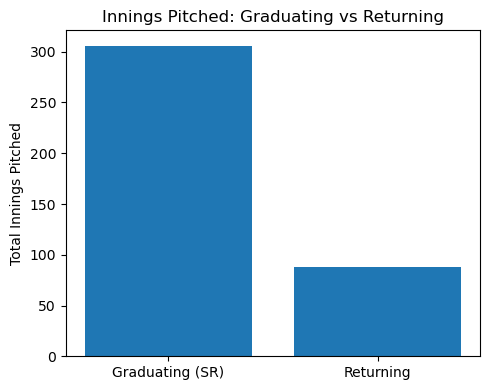

In [13]:
is_senior = clem["Class"] == "SR"
is_returning = ~is_senior

# NEXT SEASON: LOST VS RETURNING (RBI)

rbi_sr = clem[is_senior]["Hitter_RunnersBattedIn"].sum()
rbi_ret = clem[is_returning]["Hitter_RunnersBattedIn"].sum()

plt.figure(figsize=(5, 4))
plt.bar(["Graduating (SR)", "Returning"], [rbi_sr, rbi_ret])
plt.title("Team RBI: Graduating vs Returning")
plt.ylabel("Total RBI")
plt.tight_layout()
plt.show()

# NEXT SEASON: LOST VS RETURNING (INNINGS)

ip_sr = clem[is_senior]["Pitcher_InningsPitched"].sum()
ip_ret = clem[is_returning]["Pitcher_InningsPitched"].sum()

plt.figure(figsize=(5, 4))
plt.bar(["Graduating (SR)", "Returning"], [ip_sr, ip_ret])
plt.title("Innings Pitched: Graduating vs Returning")
plt.ylabel("Total Innings Pitched")
plt.tight_layout()
plt.show()


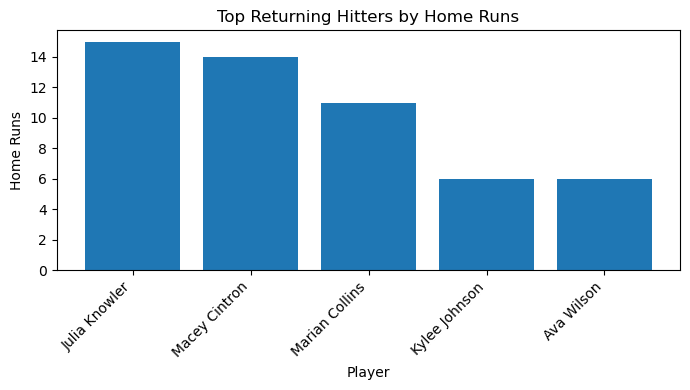

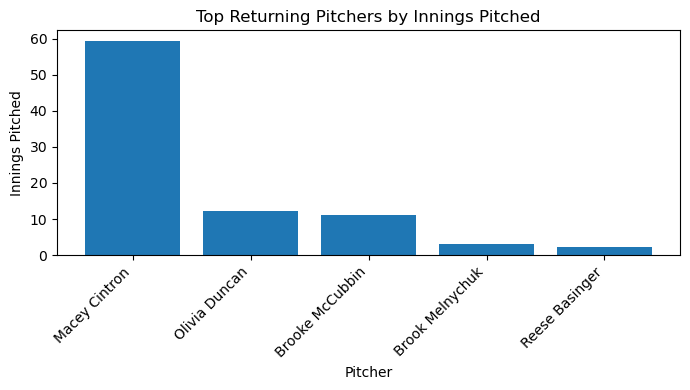

In [14]:
# NEXT SEASON: RETURNING CORE PRODUCTION

# Aggregate by player, only non-seniors
ret_batting = (
    clem[is_returning]
    .groupby("PlayerName")
    .agg(
        RBI=("Hitter_RunnersBattedIn", "sum"),
        HR=("Hitter_HomeRun", "sum")
    )
    .reset_index()
)

ret_pitching = (
    clem[is_returning]
    .groupby("PlayerName")
    .agg(
        IP=("Pitcher_InningsPitched", "sum")
    )
    .reset_index()
)

# Top returning hitters by HR or RBI
top_ret_hitters = ret_batting.sort_values("HR", ascending=False).head(5)

plt.figure(figsize=(7, 4))
plt.bar(top_ret_hitters["PlayerName"], top_ret_hitters["HR"])
plt.title("Top Returning Hitters by Home Runs")
plt.xlabel("Player")
plt.ylabel("Home Runs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Top returning pitchers by innings
top_ret_pitchers = ret_pitching.sort_values("IP", ascending=False).head(5)

plt.figure(figsize=(7, 4))
plt.bar(top_ret_pitchers["PlayerName"], top_ret_pitchers["IP"])
plt.title("Top Returning Pitchers by Innings Pitched")
plt.xlabel("Pitcher")
plt.ylabel("Innings Pitched")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
